In [14]:
import numpy as np
import os
import matplotlib.pyplot as plt
import torch
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib
import matplotlib.pyplot as plt
print(torch.cuda.is_available())  # Should return True if CUDA is enabled
print(torch.__version__)  # Check the installed PyTorch version
print(torch.version.cuda)  # Check CUDA version used by PyTorch

z = 1
dpival = 2000
cmapname = "summer"
font = {'family': 'serif', 'serif': ['Computer Modern']}
line = {'linewidth': 2/z, 'linestyle' : 'solid'}
matplotlib.rc('text', usetex=True)
matplotlib.rc('font', **font)  # pass in the font dict as kwargs
matplotlib.rc('font', weight='bold')  # pass in the font dict as kwargs
matplotlib.rc('lines', **line)
matplotlib.rc('axes', labelsize=20/z, labelweight = 'bold')
matplotlib.rc('legend', fontsize=15/z, frameon=False)
matplotlib.rc('xtick.major', size=2/z)
matplotlib.rc('ytick.major', size=2/z)
matplotlib.rc('xtick', labelsize=20/z, direction='in')
matplotlib.rc('ytick', labelsize=20/z, direction='in')

True
2.4.1
12.4


In [71]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

# ====================================
# Fourier Time Embeddings (NCSN++-Style)
# ====================================
class FourierTimeEmbedding(nn.Module):
    def __init__(self, embedding_size=64, scale=1.0):
        super().__init__()
        self.W = nn.Parameter(torch.randn(embedding_size // 2) * scale, requires_grad=False)
        self.mlp = nn.Sequential(
            nn.Linear(embedding_size, embedding_size),
            nn.SiLU(),
            nn.Linear(embedding_size, embedding_size)
        )

    def forward(self, t):
        t_proj = t[:, None] * self.W[None, :] * 2 * np.pi
        emb = torch.cat([torch.sin(t_proj), torch.cos(t_proj)], dim=-1)
        return self.mlp(emb)

class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, timesteps):
        device = timesteps.device
        half_dim = self.dim // 2
        emb = torch.log(torch.tensor(10000.0, device=device)) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, dtype=torch.float32, device=device) * -emb)
        emb = timesteps[:, None] * emb[None, :]
        emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=-1)
        return emb

class SelfAttention2D(nn.Module):
    def __init__(self, channels, num_heads=4):
        super().__init__()
        self.norm = nn.GroupNorm(8, channels)
        self.attn = nn.MultiheadAttention(embed_dim=channels, num_heads=num_heads, batch_first=True)

    def forward(self, x):
        B, C, H, W = x.shape
        x_norm = self.norm(x)
        x_reshaped = x_norm.view(B, C, -1).permute(0, 2, 1)
        attn_out, _ = self.attn(x_reshaped, x_reshaped, x_reshaped)
        attn_out = attn_out.permute(0, 2, 1).view(B, C, H, W)
        return x + attn_out

class ResidualBlock2D(nn.Module):
    def __init__(self, in_channels, out_channels, time_emb_dim, use_attention=False):
        super().__init__()
        num_groups = min(32, in_channels // 4)
        self.norm1 = nn.GroupNorm(num_groups, in_channels)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)

        num_groups = min(32, out_channels // 4)
        self.norm2 = nn.GroupNorm(num_groups, out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)

        self.residual = nn.Conv2d(in_channels, out_channels, kernel_size=1) if in_channels != out_channels else nn.Identity()
        self.time_mlp = nn.Linear(time_emb_dim, out_channels)
        self.use_attention = use_attention
        if use_attention:
            self.attention = SelfAttention2D(out_channels)

    def forward(self, x, temb):
        h = self.norm1(x)
        h = F.silu(h)
        h = self.conv1(h)
        
        t_emb = self.time_mlp(F.silu(temb)).view(temb.shape[0], -1, 1, 1)
        h = h + t_emb
        
        h = self.norm2(h)
        h = F.silu(h)
        h = self.conv2(h)
        
        if self.use_attention:
            h = self.attention(h)
        
        return h + self.residual(x)

class UNet2D(nn.Module):
    def __init__(self, in_channels=3, base_channels=64, out_channels=1, time_emb_dim=64):
        super().__init__()
        self.time_emb = nn.Sequential(
            SinusoidalPosEmb(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim * 4),
            nn.SiLU(),
            nn.Linear(time_emb_dim * 4, time_emb_dim),
        )
        self.time_embedding = FourierTimeEmbedding(time_emb_dim)
        self.init_conv = nn.Conv2d(in_channels, base_channels, kernel_size=3, padding=1)
        
        self.down1 = ResidualBlock2D(base_channels, base_channels * 2, time_emb_dim, use_attention=False)
        self.down2 = ResidualBlock2D(base_channels * 2, base_channels * 4, time_emb_dim, use_attention=True)
        
        self.bottleneck = ResidualBlock2D(base_channels * 4, base_channels * 4, time_emb_dim, use_attention=True)
        
        self.up1 = ResidualBlock2D(base_channels * 4, base_channels * 2, time_emb_dim, use_attention=True)
        self.up2 = ResidualBlock2D(base_channels * 2, base_channels, time_emb_dim, use_attention=False)
        
        self.final_conv = nn.Conv2d(base_channels, out_channels, kernel_size=3, padding=1)

    def forward(self, x, t):
        temb = self.time_embedding(t)
        x = self.init_conv(x)
        x1 = self.down1(x, temb)
        x2 = self.down2(x1, temb)

        x = self.bottleneck(x2, temb)
        x = self.up1(x + x2, temb)
        x = self.up2(x + x1, temb)

        return self.final_conv(x)


In [75]:
def sampling_combined_model_passive(N, height, width, score_model, dt, tsteps, d=2):
    x = torch.randn(N, 1, height, width).to(device)
    #samples = [x.detach()];
    for t in range(tsteps-2, 0, -1):
        #print(t)
        #xin = torch.cat((x, (t*dt) * torch.ones(x.shape[0], 1)), dim=1)
        tdt = dt*torch.ones(x.shape[0]).to(device)
        #print(tdt.device)
        with torch.no_grad():
            F = score_model(x, tdt);
        var_t = (1 - torch.exp(-2 * tdt))
        x = x + x*dt + 2*F*dt + np.sqrt(2*dt)*torch.randn(N, 1, height, width).to(device)                           # If using the total score function
        #samples.append(x.detach())
    return x.detach()


def generate_correlated_noise(covariance_matrix, image_shape):
    """
    Generate correlated Gaussian noise for MNIST-shaped data.
    Args:
        covariance_matrix (torch.Tensor): A [batch_size, 2, 2] covariance matrix.
        image_shape (tuple): Target image shape, e.g., (1, 28, 28).
    Returns:
        torch.Tensor: Correlated noise of shape [batch_size, 2, 28, 28].
    """
    batch_size = covariance_matrix.shape[0]
    height, width = image_shape[-2], image_shape[-1]  # Extract MNIST dimensions
    covariance_matrix = covariance_matrix.view(batch_size, 2, 2)  # Explicitly reshape it
    # Perform Cholesky decomposition
    L = torch.linalg.cholesky(covariance_matrix)  # Shape: [batch_size, 2, 2]

    # Generate uncorrelated standard normal noise with MNIST shape
    uncorrelated_noise = torch.randn(batch_size, 2, height, width).to(covariance_matrix.device)  # [B, 2, 28, 28]

    # Reshape for batch matrix multiplication (bmm requires 3D tensors)
    uncorrelated_noise = uncorrelated_noise.view(batch_size, 2, -1)  # Reshape to [B, 2, 784]

    # Apply the Cholesky factor to obtain correlated noise
    correlated_noise = torch.bmm(L, uncorrelated_noise)  # Shape: [B, 2, 784]

    # Reshape back to image format
    correlated_noise = correlated_noise.view(batch_size, 2, height, width)  # [B, 2, 28, 28]

    return correlated_noise


# ====================================
# 2. Compute Covariance Matrix Components
# ====================================
def compute_covariance(batch_size, Tp, Ta, tau, k):
    M11 = (Tp / k + (Ta / (k * k * tau + k))) * torch.ones(batch_size,1).to(device)
    M12 = (Ta / (1 + tau * k)) * torch.ones(batch_size,1).to(device)
    M22 = (Ta / tau) *torch.ones(batch_size,1).to(device)
    # Stack elements correctly to match batch dimension
    cov_matrix = torch.stack([
        torch.cat([M11, M12], dim=1),  # First row: [M11, M12]
        torch.cat([M12, M22], dim=1)   # Second row: [M12, M22]
    ], dim=1)  # Stack along second dimension to form [batch, 2, 2]
    return cov_matrix  # Shape: (batch_size, 2, 2)



def sampling_combined_model_active(image_shape, score_model_eta, Tp, Ta, tau, k, dt, tsteps, initial_x_value=0.0, initial_eta_value=0.0, device="cuda", d=2):
    #x_trajectories = []  # Initialize a list to store trajectories
    base_cov = compute_covariance(image_shape[0],Tp, Ta, tau, k)
    x_eta = generate_correlated_noise(base_cov, image_shape)
    #print("Shape of xeta is", x_eta.shape)
    
    for t in range(tsteps - 2, 0, -1):
        t_tensor = (t * dt) * torch.ones((image_shape[0], 1), device=device)
        x = x_eta[:,0,:,:].unsqueeze(1)
        #print("Shape of x before is", x.shape)
        eta = x_eta[:,1,:,:].unsqueeze(1)
        #print("Shape of eta before is ", eta.shape)
        with torch.no_grad():
            Feta = score_model_eta(x_eta, t_tensor)
            #print("Feta shape", Feta.shape)
        x = x + dt * (x - eta) + torch.sqrt(2 * Tp * dt) * torch.randn_like(x, device=device)
        #print("Shape of x is ", x.shape)
        eta = eta + (dt * eta / tau) + (2 * Ta / (tau * tau)) * Feta * dt + (1 / tau) * torch.sqrt(2 * Ta * dt) * torch.randn_like(eta, device=device)
        #print("Shape of eta is ", eta.shape)
        x_eta = torch.cat((x, eta), dim=1)
    return x.detach(), eta.detach()

In [80]:
epoch = 0
datidx = 59
T = 1.0
Ta = 1.0
Tp=1e-3
tau = 0.5

device = "cuda"
model_pas = UNet2D(in_channels=1, base_channels=16, out_channels=1)
model_pas = model_pas.to(device)
model_act = UNet2D(in_channels=2, base_channels=16, out_channels=1)
model_act = model_act.to(device)

checkpoint_pas = torch.load('Passive_models_T_{}/model_at_epoch_{}_datidx_{}.pth'.format(T, epoch, datidx), weights_only=True)
model_pas.load_state_dict(checkpoint_pas['model_state_dict'])
checkpoint_act = torch.load('Active_models_Ta_{}_tau_{}/model_at_epoch_{}_datidx_{}.pth'.format(Ta, tau, epoch, datidx), weights_only=True)
model_act.load_state_dict(checkpoint_act['model_state_dict'])

<All keys matched successfully>

In [81]:
dt = 0.01
tsteps = 100
T = torch.tensor(1.0, device=device)
Tp = torch.tensor(1e-3, device=device)
Ta = torch.tensor(1.0, device=device)
tau = torch.tensor(0.5, device=device)
final_data_pas = sampling_combined_model_passive(2, 28, 28, model_pas, dt, tsteps)
final_data_act = sampling_combined_model_active((3,28,28),model_act, Tp, Ta, tau, 1.0, dt, tsteps, device="cuda")

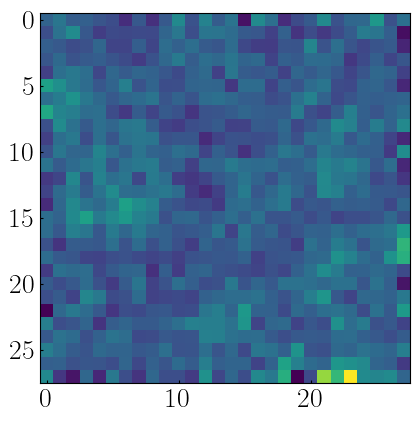

In [84]:
plt.imshow(final_data_act[0][0,0,:,:].cpu().numpy())